In [67]:
! gdown --id 1TeNeIUHPKZZr0ZqrZ0gKEV7cCSw9ikIQ
! gdown --id 1lDca_ge-GYO0iQ6_XDLWePQFMdAA2b8f

Downloading...
From: https://drive.google.com/uc?id=1TeNeIUHPKZZr0ZqrZ0gKEV7cCSw9ikIQ
To: /content/preprocessed_data.csv
100% 124M/124M [00:00<00:00, 188MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lDca_ge-GYO0iQ6_XDLWePQFMdAA2b8f
To: /content/glove_vectors
100% 128M/128M [00:00<00:00, 200MB/s]


In [68]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import hstack
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score,roc_curve,auc,plot_confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sn 
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from tabulate import tabulate
import pickle
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [69]:
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [70]:
data=pd.read_csv('preprocessed_data.csv',nrows=35000)

In [71]:
print(data.columns)

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price'],
      dtype='object')


In [72]:
lst=[]
sid = SentimentIntensityAnalyzer()
for i in data['essay']:
  ss=sid.polarity_scores(i)
  lst.append(ss)
df_polarity=pd.DataFrame.from_dict(lst)  

In [73]:
data['neg']=df_polarity['neg']
data['pos']=df_polarity['pos']
data['neu']=df_polarity['neg']
data['compound']=df_polarity['compound']

In [74]:
print(data.columns)

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price', 'neg',
       'pos', 'neu', 'compound'],
      dtype='object')


In [75]:
y=data['project_is_approved']
x=data.drop('project_is_approved',axis=1)

# **Splitting Data**

In [76]:
x_tr,x_te,y_tr,y_te=train_test_split(x,y,train_size=0.8,test_size=0.2,random_state=1)
x_tr,x_cv,y_tr,y_cv=train_test_split(x_tr,y_tr,train_size=0.75,test_size=0.25,random_state=1)

# **Vectorizing 'essay' feature**

In [77]:
vec=TfidfVectorizer(min_df=10)
vec.fit(x_tr['essay'])
tfidf_tr=vec.transform(x_tr['essay'])
tfidf_cv=vec.transform(x_cv['essay'])
tfidf_te=vec.transform(x_te['essay'])

In [78]:
tfw2v_tr=[]
dictionary=dict(zip(vec.get_feature_names_out(),list(vec.idf_)))
tfidf_words=set(vec.get_feature_names_out())
for sent in x_tr['essay']:
  vector=np.zeros(300)
  tfidf_w=0
  for word in sent.split():
    if (word in glove_words) and (word in tfidf_words):
      v=model[word]
      tfidf=dictionary[word]*(sent.count(word)/len(sent.split()))
      vector+=tfidf*v
      tfidf_w+=tfidf
  if tfidf_w!=0:
    vector=vector/tfidf_w
    tfw2v_tr.append(vector)  

In [79]:
tfw2v_cv=[]
for sent in x_cv['essay']:
  vector=np.zeros(300)
  tfidf_w=0
  for word in sent.split():
    if (word in glove_words) and (word in tfidf_words):
      v=model[word]
      tfidf=dictionary[word]*(sent.count(word)/len(sent.split()))
      vector+=tfidf*v
      tfidf_w+=tfidf
  if tfidf_w!=0:
    vector=vector/tfidf_w
    tfw2v_cv.append(vector)

In [80]:
tfw2v_te=[]
for sent in x_te['essay']:
  vector=np.zeros(300)
  tfidf_w=0
  for word in sent.split():
    if (word in glove_words) and (word in tfidf_words):
      v=model[word]
      tfidf=dictionary[word]*(sent.count(word)/len(sent.split()))
      vector+=tfidf*v
      tfidf_w+=tfidf
  if tfidf_w!=0:
    vector=vector/tfidf_w
    tfw2v_te.append(vector)
tfw2v_tr=np.array(tfw2v_tr)
tfw2v_cv=np.array(tfw2v_cv)
tfw2v_te=np.array(tfw2v_te)  
print(tfw2v_tr.shape,tfw2v_cv.shape,tfw2v_te.shape)  

(21000, 300) (7000, 300) (7000, 300)


# **Response coding Categorical features**

In [81]:
from functools import total_ordering
ss=list(set(x_tr['school_state'].values))
print(ss)
ss0=[]
ss1=[]
for i in ss:
  count=0
  total=0
  for j in range(len(x_tr['school_state'])):
    if x_tr['school_state'].values[j]==i:
      total+=1
      if y_tr.values[j]==0:
        count+=1
    else:
      continue    
  prob=count/total      
  ss0.append((i,prob))
  ss1.append((i,1-prob))

['va', 'md', 'sc', 'fl', 'or', 'mo', 'oh', 'mi', 'nj', 'ak', 'wi', 'sd', 'me', 'nv', 'nh', 'la', 'wa', 'nd', 'ia', 'ct', 'dc', 'de', 'ok', 'il', 'tn', 'ga', 'ut', 'mt', 'ny', 'ma', 'ri', 'ca', 'wy', 'ky', 'ms', 'nm', 'co', 'pa', 'vt', 'nc', 'in', 'ne', 'ar', 'id', 'mn', 'tx', 'al', 'hi', 'ks', 'az', 'wv']


In [82]:
ss0=dict(ss0)
ss1=dict(ss1)
ss_p0_tr=[]
ss_p1_tr=[]
ss_p0_cv=[]
ss_p1_cv=[]
ss_p0_te=[]
ss_p1_te=[]
for i in range(len(x_tr)):
  if x_tr['school_state'].values[i] in ss:
    ss_p0_tr.append(ss0[x_tr['school_state'].values[i]])
    ss_p1_tr.append(ss1[x_tr['school_state'].values[i]])
for i in range(len(x_cv)):
  if x_cv['school_state'].values[i] in ss:
    ss_p0_cv.append(ss0[x_cv['school_state'].values[i]])
    ss_p1_cv.append(ss1[x_cv['school_state'].values[i]])
  else:
    ss_p0_cv.append(0.5)
    ss_p1_cv.append(0.5)   
for i in range(len(x_te)):
  if x_te['school_state'].values[i] in ss:
    ss_p0_te.append(ss0[x_te['school_state'].values[i]])
    ss_p1_te.append(ss1[x_te['school_state'].values[i]])
  else:
    ss_p0_te.append(0.5)
    ss_p1_te.append(0.5) 
ss_p0_tr=np.array(ss_p0_tr).reshape(-1,1)
ss_p1_tr=np.array(ss_p1_tr).reshape(-1,1)
ss_p0_cv=np.array(ss_p0_cv).reshape(-1,1)
ss_p1_cv=np.array(ss_p1_cv).reshape(-1,1)
ss_p0_te=np.array(ss_p0_te).reshape(-1,1)
ss_p1_te=np.array(ss_p1_te).reshape(-1,1)        

In [83]:
print(ss_p0_tr.shape,ss_p0_cv.shape,ss_p0_te.shape)

(21000, 1) (7000, 1) (7000, 1)


In [84]:
tp=list(set(x_tr['teacher_prefix'].values))
print(tp)
tp0=[]
tp1=[]
for i in tp:
  count=0
  total=0
  for j in range(len(x_tr['teacher_prefix'])):
    if x_tr['teacher_prefix'].values[j]==i:
      total+=1
      if y_tr.values[j]==0:
        count+=1
    else:
      continue    
  prob=count/total      
  tp0.append((i,prob))
  tp1.append((i,1-prob))

['mrs', 'dr', 'teacher', 'ms', 'mr']


In [85]:
tp0=dict(tp0)
tp1=dict(tp1)
tp_p0_tr=[]
tp_p1_tr=[]
tp_p0_cv=[]
tp_p1_cv=[]
tp_p0_te=[]
tp_p1_te=[]
for i in range(len(x_tr)):
  if x_tr['teacher_prefix'].values[i] in tp:
    tp_p0_tr.append(tp0[x_tr['teacher_prefix'].values[i]])
    tp_p1_tr.append(tp1[x_tr['teacher_prefix'].values[i]])
for i in range(len(x_cv)):
  if x_cv['teacher_prefix'].values[i] in tp:
    tp_p0_cv.append(tp0[x_cv['teacher_prefix'].values[i]])
    tp_p1_cv.append(tp1[x_cv['teacher_prefix'].values[i]])
  else:
    tp_p0_cv.append(0.5)
    tp_p1_cv.append(0.5)   
for i in range(len(x_te)):
  if x_te['teacher_prefix'].values[i] in tp:
    tp_p0_te.append(tp0[x_te['teacher_prefix'].values[i]])
    tp_p1_te.append(tp1[x_te['teacher_prefix'].values[i]])
  else:
    tp_p0_te.append(0.5)
    tp_p1_te.append(0.5) 
tp_p0_tr=np.array(tp_p0_tr).reshape(-1,1)
tp_p1_tr=np.array(tp_p1_tr).reshape(-1,1)
tp_p0_cv=np.array(tp_p0_cv).reshape(-1,1)
tp_p1_cv=np.array(tp_p1_cv).reshape(-1,1)
tp_p0_te=np.array(tp_p0_te).reshape(-1,1)
tp_p1_te=np.array(tp_p1_te).reshape(-1,1)

In [86]:
print(tp_p0_tr.shape,tp_p0_cv.shape,tp_p0_te.shape)

(21000, 1) (7000, 1) (7000, 1)


In [87]:
pgc=list(set(x_tr['project_grade_category'].values))
print(pgc)
pgc0=[]
pgc1=[]
for i in pgc:
  count=0
  total=0
  for j in range(len(x_tr['project_grade_category'])):
    if x_tr['project_grade_category'].values[j]==i:
      total+=1
      if y_tr.values[j]==0:
        count+=1
    else:
      continue    
  prob=count/total      
  pgc0.append((i,prob))
  pgc1.append((i,1-prob))

['grades_6_8', 'grades_prek_2', 'grades_3_5', 'grades_9_12']


In [88]:
pgc0=dict(pgc0)
pgc1=dict(pgc1)
pgc_p0_tr=[]
pgc_p1_tr=[]
pgc_p0_cv=[]
pgc_p1_cv=[]
pgc_p0_te=[]
pgc_p1_te=[]
for i in range(len(x_tr)):
  if x_tr['project_grade_category'].values[i] in pgc:
    pgc_p0_tr.append(pgc0[x_tr['project_grade_category'].values[i]])
    pgc_p1_tr.append(pgc1[x_tr['project_grade_category'].values[i]])
for i in range(len(x_cv)):
  if x_cv['project_grade_category'].values[i] in pgc:
    pgc_p0_cv.append(pgc0[x_cv['project_grade_category'].values[i]])
    pgc_p1_cv.append(pgc1[x_cv['project_grade_category'].values[i]])
  else:
    pgc_p0_cv.append(0.5)
    pgc_p1_cv.append(0.5)   
for i in range(len(x_te)):
  if x_te['project_grade_category'].values[i] in pgc:
    pgc_p0_te.append(pgc0[x_te['project_grade_category'].values[i]])
    pgc_p1_te.append(pgc1[x_te['project_grade_category'].values[i]])
  else:
    pgc_p0_te.append(0.5)
    pgc_p1_te.append(0.5) 
pgc_p0_tr=np.array(pgc_p0_tr).reshape(-1,1)
pgc_p1_tr=np.array(pgc_p1_tr).reshape(-1,1)
pgc_p0_cv=np.array(pgc_p0_cv).reshape(-1,1)
pgc_p1_cv=np.array(pgc_p1_cv).reshape(-1,1)
pgc_p0_te=np.array(pgc_p0_te).reshape(-1,1)
pgc_p1_te=np.array(pgc_p1_te).reshape(-1,1)

In [89]:
print(pgc_p0_tr.shape,pgc_p0_cv.shape,pgc_p0_te.shape)

(21000, 1) (7000, 1) (7000, 1)


In [90]:
cc=list(set(x_tr['clean_categories'].values))
print(cc)
cc0=[]
cc1=[]
for i in cc:
  count=0
  total=0
  for j in range(len(x_tr['clean_categories'])):
    if x_tr['clean_categories'].values[j]==i:
      total+=1
      if y_tr.values[j]==0:
        count+=1
    else:
      continue    
  prob=count/total      
  cc0.append((i,prob))
  cc1.append((i,1-prob))

['appliedlearning literacy_language', 'literacy_language appliedlearning', 'specialneeds', 'appliedlearning', 'history_civics specialneeds', 'history_civics math_science', 'math_science history_civics', 'music_arts appliedlearning', 'history_civics health_sports', 'health_sports specialneeds', 'music_arts', 'literacy_language health_sports', 'history_civics appliedlearning', 'math_science music_arts', 'specialneeds health_sports', 'math_science health_sports', 'math_science specialneeds', 'health_sports music_arts', 'music_arts health_sports', 'specialneeds music_arts', 'literacy_language music_arts', 'math_science appliedlearning', 'literacy_language history_civics', 'history_civics', 'history_civics literacy_language', 'appliedlearning health_sports', 'history_civics music_arts', 'health_sports literacy_language', 'appliedlearning history_civics', 'literacy_language specialneeds', 'appliedlearning math_science', 'music_arts specialneeds', 'math_science literacy_language', 'literacy_l

In [91]:
cc0=dict(cc0)
cc1=dict(cc1)
cc_p0_tr=[]
cc_p1_tr=[]
cc_p0_cv=[]
cc_p1_cv=[]
cc_p0_te=[]
cc_p1_te=[]
for i in range(len(x_tr)):
  if x_tr['clean_categories'].values[i] in cc:
    cc_p0_tr.append(cc0[x_tr['clean_categories'].values[i]])
    cc_p1_tr.append(cc1[x_tr['clean_categories'].values[i]])
for i in range(len(x_cv)):
  if x_cv['clean_categories'].values[i] in cc:
    cc_p0_cv.append(cc0[x_cv['clean_categories'].values[i]])
    cc_p1_cv.append(cc1[x_cv['clean_categories'].values[i]])
  else:
    cc_p0_cv.append(0.5)
    cc_p1_cv.append(0.5)   
for i in range(len(x_te)):
  if x_te['clean_categories'].values[i] in cc:
    cc_p0_te.append(cc0[x_te['clean_categories'].values[i]])
    cc_p1_te.append(cc1[x_te['clean_categories'].values[i]])
  else:
    cc_p0_te.append(0.5)
    cc_p1_te.append(0.5) 
cc_p0_tr=np.array(cc_p0_tr).reshape(-1,1)
cc_p1_tr=np.array(cc_p1_tr).reshape(-1,1)
cc_p0_cv=np.array(cc_p0_cv).reshape(-1,1)
cc_p1_cv=np.array(cc_p1_cv).reshape(-1,1)
cc_p0_te=np.array(cc_p0_te).reshape(-1,1)
cc_p1_te=np.array(cc_p1_te).reshape(-1,1)

In [92]:
print(cc_p0_tr.shape,cc_p0_cv.shape,cc_p0_te.shape)

(21000, 1) (7000, 1) (7000, 1)


In [93]:
csc=list(set(x_tr['clean_subcategories'].values))
print(csc)
csc0=[]
csc1=[]
for i in csc:
  count=0
  total=0
  for j in range(len(x_tr['clean_subcategories'])):
    if x_tr['clean_subcategories'].values[j]==i:
      total+=1
      if y_tr.values[j]==0:
        count+=1
    else:
      continue    
  prob=count/total      
  csc0.append((i,prob))
  csc1.append((i,1-prob))

['literacy mathematics', 'extracurricular visualarts', 'foreignlanguages socialsciences', 'visualarts', 'earlydevelopment health_wellness', 'literature_writing music', 'health_wellness performingarts', 'history_geography music', 'parentinvolvement socialsciences', 'health_wellness other', 'environmentalscience visualarts', 'civics_government financialliteracy', 'gym_fitness mathematics', 'foreignlanguages music', 'health_wellness literacy', 'earlydevelopment visualarts', 'college_careerprep gym_fitness', 'environmentalscience music', 'appliedsciences esl', 'history_geography', 'charactereducation performingarts', 'health_lifescience music', 'college_careerprep visualarts', 'nutritioneducation other', 'charactereducation visualarts', 'gym_fitness literature_writing', 'civics_government literacy', 'extracurricular other', 'health_lifescience socialsciences', 'appliedsciences college_careerprep', 'extracurricular literacy', 'earlydevelopment performingarts', 'civics_government economics',

In [94]:
csc0=dict(csc0)
csc1=dict(csc1)
csc_p0_tr=[]
csc_p1_tr=[]
csc_p0_cv=[]
csc_p1_cv=[]
csc_p0_te=[]
csc_p1_te=[]
for i in range(len(x_tr)):
  if x_tr['clean_subcategories'].values[i] in csc:
    csc_p0_tr.append(csc0[x_tr['clean_subcategories'].values[i]])
    csc_p1_tr.append(csc1[x_tr['clean_subcategories'].values[i]])
for i in range(len(x_cv)):
  if x_cv['clean_subcategories'].values[i] in csc:
    csc_p0_cv.append(csc0[x_cv['clean_subcategories'].values[i]])
    csc_p1_cv.append(csc1[x_cv['clean_subcategories'].values[i]])
  else:
    csc_p0_cv.append(0.5)
    csc_p1_cv.append(0.5)   
for i in range(len(x_te)):
  if x_te['clean_subcategories'].values[i] in csc:
    csc_p0_te.append(csc0[x_te['clean_subcategories'].values[i]])
    csc_p1_te.append(csc1[x_te['clean_subcategories'].values[i]])
  else:
    csc_p0_te.append(0.5)
    csc_p1_te.append(0.5) 
csc_p0_tr=np.array(csc_p0_tr).reshape(-1,1)
csc_p1_tr=np.array(csc_p1_tr).reshape(-1,1)
csc_p0_cv=np.array(csc_p0_cv).reshape(-1,1)
csc_p1_cv=np.array(csc_p1_cv).reshape(-1,1)
csc_p0_te=np.array(csc_p0_te).reshape(-1,1)
csc_p1_te=np.array(csc_p1_te).reshape(-1,1)

In [95]:
print(csc_p0_tr.shape,csc_p0_cv.shape,csc_p0_te.shape)

(21000, 1) (7000, 1) (7000, 1)


# **Normalizing numerical features**

In [96]:
scaler=MinMaxScaler()
tnppp_tr=scaler.fit_transform(x_tr['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
tnppp_cv=scaler.fit_transform(x_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
tnppp_te=scaler.fit_transform(x_te['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
print(tnppp_tr.shape,tnppp_cv.shape,tnppp_te.shape)

(21000, 1) (7000, 1) (7000, 1)


In [97]:
price_tr=scaler.fit_transform(x_tr['price'].values.reshape(-1,1))
price_cv=scaler.fit_transform(x_cv['price'].values.reshape(-1,1))
price_te=scaler.fit_transform(x_te['price'].values.reshape(-1,1))
print(price_tr.shape,price_cv.shape,price_te.shape)

(21000, 1) (7000, 1) (7000, 1)


In [98]:
print(tfidf_tr.shape)
print(x_tr.columns)

(21000, 8538)
Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'clean_categories',
       'clean_subcategories', 'essay', 'price', 'neg', 'pos', 'neu',
       'compound'],
      dtype='object')


In [99]:
neg_tr=x_tr['neg'].values.reshape(-1,1)
pos_tr=x_tr['pos'].values.reshape(-1,1)
neu_tr=x_tr['neu'].values.reshape(-1,1)
com_tr=x_tr['compound'].values.reshape(-1,1)
neg_cv=x_cv['neg'].values.reshape(-1,1)
pos_cv=x_cv['pos'].values.reshape(-1,1)
neu_cv=x_cv['neu'].values.reshape(-1,1)
com_cv=x_cv['compound'].values.reshape(-1,1)
neg_te=x_te['neg'].values.reshape(-1,1)
pos_te=x_te['pos'].values.reshape(-1,1)
neu_te=x_te['neu'].values.reshape(-1,1)
com_te=x_te['compound'].values.reshape(-1,1)

# **Stacking all encoded features**

In [100]:
set1_tr=hstack((tfidf_tr,ss_p0_tr,ss_p1_tr,tp_p0_tr,tp_p1_tr,pgc_p0_tr,pgc_p1_tr,cc_p0_tr,cc_p1_tr,csc_p0_tr,csc_p1_tr,tnppp_tr,price_tr,neg_tr,pos_tr,neu_tr,com_tr)).tocsr()
set1_cv=hstack((tfidf_cv,ss_p0_cv,ss_p1_cv,tp_p0_cv,tp_p1_cv,pgc_p0_cv,pgc_p1_cv,cc_p0_cv,cc_p1_cv,csc_p0_cv,csc_p1_cv,tnppp_cv,price_cv,neg_cv,pos_cv,neu_cv,com_cv)).tocsr()
set1_te=hstack((tfidf_te,ss_p0_te,ss_p1_te,tp_p0_te,tp_p1_te,pgc_p0_te,pgc_p1_te,cc_p0_te,cc_p1_te,csc_p0_te,csc_p1_te,tnppp_te,price_te,neg_te,pos_te,neu_te,com_te)).tocsr()
print(set1_tr.shape,set1_cv.shape,set1_te.shape)

(21000, 8554) (7000, 8554) (7000, 8554)


In [101]:
print(tfw2v_tr.shape)

(21000, 300)


In [114]:
set2_tr=np.hstack((tfw2v_tr,ss_p0_tr,ss_p1_tr,tp_p0_tr,tp_p1_tr,pgc_p0_tr,pgc_p1_tr,cc_p0_tr,cc_p1_tr,csc_p0_tr,csc_p1_tr,tnppp_tr,price_tr,neg_tr,pos_tr,neu_tr,com_tr))
set2_cv=np.hstack((tfw2v_cv,ss_p0_cv,ss_p1_cv,tp_p0_cv,tp_p1_cv,pgc_p0_cv,pgc_p1_cv,cc_p0_cv,cc_p1_cv,csc_p0_cv,csc_p1_cv,tnppp_cv,price_cv,neg_cv,pos_cv,neu_cv,com_cv))
set2_te=np.hstack((tfw2v_te,ss_p0_te,ss_p1_te,tp_p0_te,tp_p1_te,pgc_p0_te,pgc_p1_te,cc_p0_te,cc_p1_te,csc_p0_te,csc_p1_te,tnppp_te,price_te,neg_te,pos_te,neu_te,com_te))
print(set2_tr.shape,set2_cv.shape,set2_te.shape)

(21000, 316) (7000, 316) (7000, 316)


# **SET 1**

In [104]:
clf=GradientBoostingClassifier(random_state=1)
max_depth=[1,3,10,20]
n_estimators=[5,10,15,20]
auc_tr=[]
auc_cv=[]
for i in max_depth:
  for j in n_estimators:
    clf=GradientBoostingClassifier(max_depth=i,n_estimators=j)
    clf.fit(set1_tr,y_tr)
    y_pred_tr=clf.predict(set1_tr)
    y_pred_cv=clf.predict(set1_cv)
    auc_tr.append(roc_auc_score(y_tr,y_pred_tr))
    auc_cv.append(roc_auc_score(y_cv,y_pred_cv))

In [105]:
x1 = [1,1,1,1,3,3,3,3,10,10,10,10,20,20,20,20]
y1 = [5,10,15,20,5,10,15,20,5,10,15,20,5,10,15,20]
z1 = auc_tr
x2= [1,1,1,1,3,3,3,3,10,10,10,10,20,20,20,20]
y2 = [5,10,15,20,5,10,15,20,5,10,15,20,5,10,15,20]
z2 = auc_cv

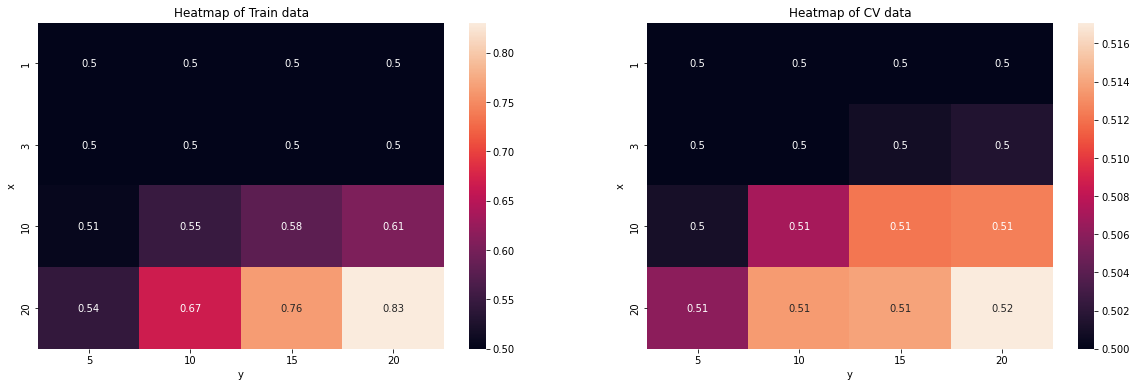

In [106]:
data1=pd.DataFrame(data={'x':x1,'y':y1,'z':z1})
data1=data1.pivot(index='x',columns='y',values='z')
data2=pd.DataFrame(data={'x':x2,'y':y2,'z':z2})
data2=data2.pivot(index='x',columns='y',values='z')
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.title('Heatmap of Train data')
sn.heatmap(data1,annot=True)
plt.subplot(1,2,2)
plt.title('Heatmap of CV data')
sn.heatmap(data2,annot=True)
plt.show()

In [110]:
print(auc_cv)
best_clf1=GradientBoostingClassifier(n_estimators=10,max_depth=3,random_state=1)

[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5008423388642458, 0.5015157873383548, 0.5010523953086977, 0.5070680393484869, 0.5122044046425918, 0.5125379592499889, 0.5060177571262274, 0.5135534146772479, 0.5139323615118366, 0.5170895474379297]


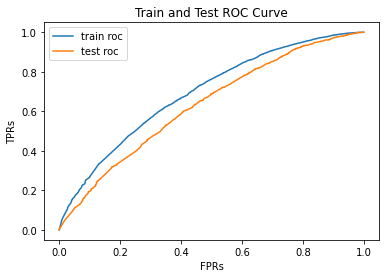

In [111]:
best_clf1.fit(set1_tr,y_tr)
train_prob=list(best_clf1.predict_proba(set1_tr)[:,1])
test_prob=list(best_clf1.predict_proba(set1_te)[:,1])
train_fpr,train_tpr,threshold=roc_curve(y_tr,train_prob)
test_fpr,test_tpr,threshold=roc_curve(y_te,test_prob)
plt.plot(train_fpr,train_tpr,label='train roc')
plt.plot(test_fpr,test_tpr,label='test roc')
plt.xlabel('FPRs')
plt.ylabel('TPRs')
plt.legend()
plt.title('Train and Test ROC Curve')
plt.show()

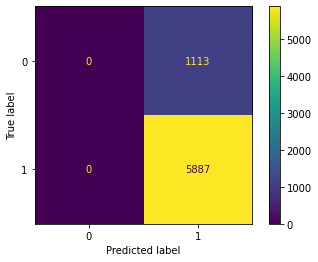

In [112]:
plot_confusion_matrix(best_clf1,set1_te,y_te) 
plt.show()

# **SET 2**

In [115]:
auc_tr=[]
auc_cv=[]
for i in max_depth:
  for j in n_estimators:
    clf=GradientBoostingClassifier(max_depth=i,n_estimators=j)
    clf.fit(set2_tr,y_tr)
    y_pred_tr=clf.predict(set2_tr)
    y_pred_cv=clf.predict(set2_cv)
    auc_tr.append(roc_auc_score(y_tr,y_pred_tr))
    auc_cv.append(roc_auc_score(y_cv,y_pred_cv))

In [116]:
x1 = [1,1,1,1,3,3,3,3,10,10,10,10,20,20,20,20]
y1 = [5,10,15,20,5,10,15,20,5,10,15,20,5,10,15,20]
z1 = auc_tr
x2= [1,1,1,1,3,3,3,3,10,10,10,10,20,20,20,20]
y2 = [5,10,15,20,5,10,15,20,5,10,15,20,5,10,15,20]
z2 = auc_cv

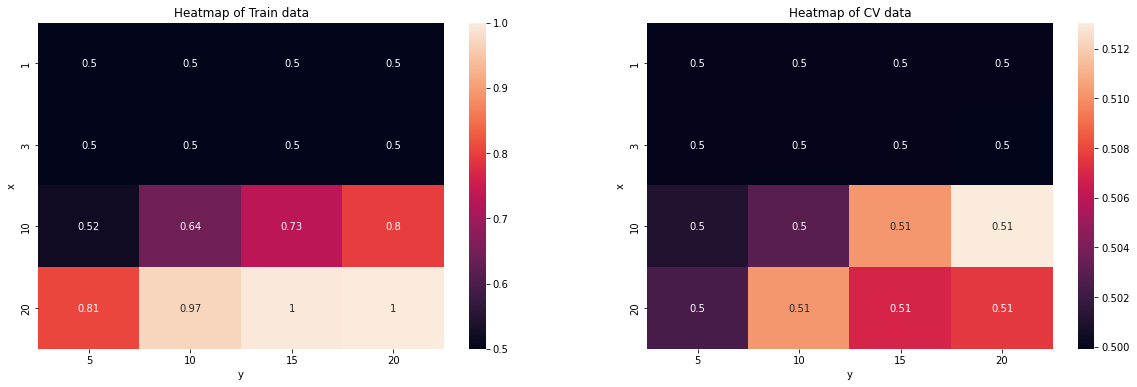

In [117]:
data1=pd.DataFrame(data={'x':x1,'y':y1,'z':z1})
data1=data1.pivot(index='x',columns='y',values='z')
data2=pd.DataFrame(data={'x':x2,'y':y2,'z':z2})
data2=data2.pivot(index='x',columns='y',values='z')
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.title('Heatmap of Train data')
sn.heatmap(data1,annot=True)
plt.subplot(1,2,2)
plt.title('Heatmap of CV data')
sn.heatmap(data2,annot=True)
plt.show()

In [118]:
print(auc_cv)

[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.4999155548049316, 0.5010523953086977, 0.5029429033087647, 0.5102252252745799, 0.5130446304203993, 0.5023950660840392, 0.5102685044153332, 0.506938201926227, 0.5075683712595827]


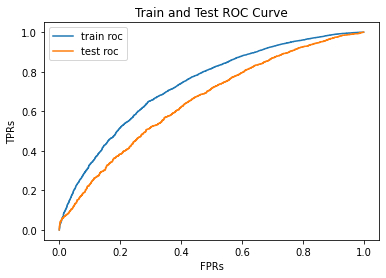

In [120]:
best_clf2=GradientBoostingClassifier(n_estimators=20,max_depth=3,random_state=1)
best_clf2.fit(set2_tr,y_tr)
train_prob=list(best_clf2.predict_proba(set2_tr)[:,1])
test_prob=list(best_clf2.predict_proba(set2_te)[:,1])
train_fpr,train_tpr,threshold=roc_curve(y_tr,train_prob)
test_fpr,test_tpr,threshold=roc_curve(y_te,test_prob)
plt.plot(train_fpr,train_tpr,label='train roc')
plt.plot(test_fpr,test_tpr,label='test roc')
plt.xlabel('FPRs')
plt.ylabel('TPRs')
plt.legend()
plt.title('Train and Test ROC Curve')
plt.show()

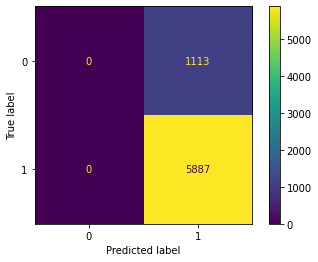

In [121]:
plot_confusion_matrix(best_clf2,set2_te,y_te) 
plt.show()

In [122]:
y_pred1=best_clf1.predict(set1_te)
auc1=roc_auc_score(y_te,y_pred1)
y_pred2=best_clf2.predict(set2_te)
auc2=roc_auc_score(y_te,y_pred2)

In [125]:
print(best_clf1.get_params(),best_clf2.get_params())

{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_iter_no_change': None, 'random_state': 1, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False} {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 20, 'n_iter_no_change': None, 'random_state': 1, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


# **Conclusion:**

In [127]:
t=[['TFIDF','Gradient Boosting Classifier','3','10',auc1],
   ['TFIDF Word2Vec','Gradient Boosting Classifier','3','20',auc2]]
print(tabulate(t,headers=['Vectorizer','Model','max_depth','n_estimators','AUC Score']))

Vectorizer      Model                           max_depth    n_estimators    AUC Score
--------------  ----------------------------  -----------  --------------  -----------
TFIDF           Gradient Boosting Classifier            3              10          0.5
TFIDF Word2Vec  Gradient Boosting Classifier            3              20          0.5
